# TP 5a - RNN

This lab session will introduce you to RNNs with a toy problem. I simulated 3 types of insect motions in 2D: *ant* (steady), *slug* (fluctuating) and *grasshopper* (explosive). 2D positions over time are given as (num_times, 2) arrays; the first row contains the x coordinates, the second row the y coordinates. Those will be fed to an RNN, which you will train to recognize the three motion types.



*   First download the dataset at https://seafile.unistra.fr/f/18a7fcac43574a2bbe18/?dl=1
*   Move the dataset to your google drive folder or wherever you prefer

 

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as amt
from matplotlib import rc
import numpy as np
from timeit import default_timer as timer
import pickle
import random

rc('animation', html='jshtml')
random.seed(2111994)
device = "cuda:0" if torch.cuda.is_available else "cpu"
print(device)

cuda:0


## Dataset

In [ ]:
# mount the drive where your dataset is available
from google.colab import drive
drive.mount('/content/drive')
filepath='/content/drive/MyDrive/datasets/' # add your own path. Where to save the dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load it using the following cell:

In [ ]:
DATA_PATH = filepath + "bugs.pickle"

with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

x_train = data["x_train"]
y_train = data["y_train"]
x_val   =  data["x_val"]
y_val   =  data["y_val"]

x_train = [np.transpose(v) for v in x_train]
x_val = [np.transpose(v) for v in x_val]

This cell will load a few helpful functions for previewing.

In [ ]:
BBOX_MARGIN = 1.2
ANIM_REFRESH_TIME = 1000 / 60

def trajectory_bbox(positions): 
  x_min = np.min(positions[:, 0])
  x_max = np.max(positions[:, 0])
  y_min = np.min(positions[:, 1])
  y_max = np.max(positions[:, 1])
  delta_x = x_max - x_min
  delta_y = y_max - y_min
  delta = BBOX_MARGIN * max(delta_x, delta_y) / 2
  cx = (x_min + x_max) / 2
  cy = (y_min + y_max) / 2
  bbox_x1 = cx - delta
  bbox_x2 = cx + delta
  bbox_y1 = cy - delta
  bbox_y2 = cy + delta
  return bbox_x1, bbox_x2, bbox_y1, bbox_y2


def plot_trajectory(positions, label, save_png=None):
  bbox = trajectory_bbox(positions)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(positions[:, 0], positions[:, 1])
  ax.set_xlim(bbox[0], bbox[1])
  ax.set_ylim(bbox[2], bbox[3])
  ax.set_aspect(1.0)
  ax.set_title(label)
  plt.show()


def animate_motion(positions, n_frames, save_gif=None):
  bbox = trajectory_bbox(positions)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  handle = ax.scatter([], [], marker=".", color="r", alpha=1)

  def init():
    ax.set_xlim(bbox[0], bbox[1])
    ax.set_ylim(bbox[2], bbox[3])
    ax.set_aspect(1.0)
    return handle,

  def update(id_t):
    handle.set_offsets(positions[id_t, :])
    return handle,

  anim = amt.FuncAnimation(
    fig,
    update,
    frames=np.arange(n_frames),
    interval=ANIM_REFRESH_TIME,
    init_func=init,
    blit=False,
    repeat=False
  )
  return anim

#### QUESTION 1

Preview a sample here; change the value of *id_sample* a few times to get familiar with the different motion types.

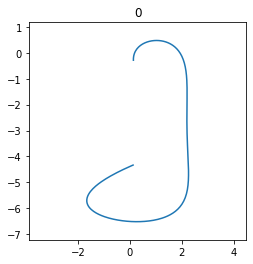

In [ ]:
ID_SAMPLE = 0
plot_trajectory(x_train[ID_SAMPLE], y_train[ID_SAMPLE])



We will package all of this into pytorch datasets.

In [ ]:
# Create custom dataset
from torch.utils.data import Dataset, DataLoader

class bug_motion(Dataset):
    """bugs motion dataset."""

    def __init__(self, x, y):
        """
        Args:
            x: bug motion
            y: bug type (label)
        """
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x_bug = self.x[idx]
        y_bug = self.y[idx]
            
        return (x_bug, y_bug)

In [ ]:
BATCH_SIZE = 48

train_dataset = bug_motion(x_train, y_train)
val_dataset = bug_motion(x_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model


We will use PyTorch LSTM module for our RNN.

In [ ]:
class MotionLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_dim):
        super(MotionLSTM, self).__init__()

        # Defining the number of layers
        self.hidden_size = hidden_size

        # LSTM layers
        # input_size – The number of expected features in the input x
        # hidden_size – The number of features in the hidden state h
        # batch first = True results in input format of (N,L,Hin​) and output format of (N,L,Hout​) 
        #   with N the number of samples in the batch, L the sequence length and H the hidden states
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)

        # Fully connected layer
        self.fc1 = torch.nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        # by default, h0 and c0 are set to torch.zeros        
        out, (final_hidden_state, final_cell_state) = self.lstm(x)
        
        # Taking the last LSTM cell output for feeding in the Linear layer of classification
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc1(out)
        
        return out

## Training

Here is an optimizer for performing gradient descent, as well as the functions for one iteration of training and one iteration of evaluation.

*You have seen them before; those are very generic. Being comfortable with them is highly valuable for your general understanding of deep learning*

In [ ]:
def train_step(inputs, labels, lstm_model, optim):
    lstm_model.train()
    data = inputs.to(device)
    optim.zero_grad()
    outp = lstm_model(data.float())
    loss = torch.mean(torch.nn.CrossEntropyLoss()(outp.to('cpu'), labels))
    loss.backward()
    optim.step()
    del data
    del outp
    torch.cuda.empty_cache()
    return loss.item()

def eval_step(inputs, labels, lstm_model):
    lstm_model.eval()
    data = inputs.to(device)
    outp = lstm_model(data.float())
    pred = torch.argmax(outp, axis=1)
    acc = torch.mean((labels == pred.to('cpu')).float())
    del data
    del pred
    torch.cuda.empty_cache()
    return acc

In [ ]:
input_size = 2
hidden_size = 32
output_dim = 3
LEARNING_RATE = 0.003

lstm_0 = MotionLSTM(input_size, hidden_size, output_dim)
lstm_0 = lstm_0.to(device)

optim_0 = torch.optim.RMSprop(lstm_0.parameters(), lr=LEARNING_RATE)

torch.save({
            'model_state_dict': lstm_0.state_dict(),
            'optimizer_state_dict': optim_0.state_dict(),
            }, 'start')

 #### QUESTION 2

Train the RNN for 50000 iterations; report training loss and validation acccuracy every 200 iterations.

ITER  200: training loss       = 1.1005
        : validation accuracy = 0.3308
______________________________________
ITER  400: training loss       = 1.0986
        : validation accuracy = 0.3058
______________________________________
ITER  600: training loss       = 1.0977
        : validation accuracy = 0.3233
______________________________________
ITER  800: training loss       = 1.0972
        : validation accuracy = 0.3108
______________________________________
ITER  1000: training loss       = 1.0968
        : validation accuracy = 0.3217
______________________________________
ITER  1200: training loss       = 1.0968
        : validation accuracy = 0.3333
______________________________________
ITER  1400: training loss       = 1.0962
        : validation accuracy = 0.3217
______________________________________
ITER  1600: training loss       = 1.0953
        : validation accuracy = 0.3125
______________________________________
ITER  1800: training loss       = 1.0947
        : v

Text(0, 0.5, 'validation accuracy')

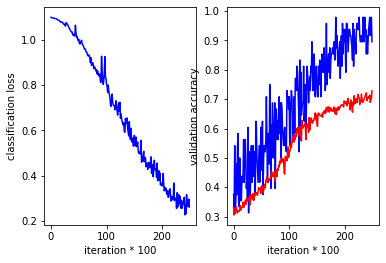

In [ ]:
start_t = timer()

average_training_losses = []
training_losses = []
average_val_accs = []
average_train_accs = []
val_accs = []
train_accs = []
id_iter = 0
max_iter = 50000
stop_epoch = False

for epoch in range(10000):
  for (x_train_in, y_train_in) in train_dataloader:
    training_losses.append(train_step(x_train_in.float(), y_train_in, lstm_0, optim_0))  # training iteration
    
    id_iter = id_iter + 1

    if id_iter % 200 == 0:
      for x_val_in, y_val_in in val_dataloader:  # validation
        val_accs.append(eval_step(x_val_in.float(), y_val_in, lstm_0))
      for x_val_in, y_val_in in train_dataloader:  # training
        train_accs.append(eval_step(x_train_in.float(), y_train_in, lstm_0))
      # report average val acc
      average_val_accs.append(sum(val_accs) / len(val_accs))
      average_train_accs.append(sum(train_accs) / len(train_accs))
      # report average training loss
      average_training_losses.append(sum(training_losses) / len(training_losses))
      # reset averages
      training_losses = []
      val_accs = []
      train_accs = []
      # print info
      print("ITER  {}: training loss       = {:.4f}".format(id_iter, average_training_losses[-1]))
      print("        : validation accuracy = {:.4f}".format(average_val_accs[-1]))
      print("______________________________________")
    
    if id_iter >= max_iter:
      stop_epoch = True
      break
    
  if stop_epoch:
    break

end_t = timer()
print("time_elapsed: {}".format(end_t - start_t))

# plots
times = list(range(len(average_training_losses)))

fig = plt.figure()

ax = fig.add_subplot(121)
ax.plot(times, average_training_losses, 'b')
ax.set_xlabel("iteration * 200")
ax.set_ylabel("classification loss")

ax = fig.add_subplot(122)
ax.plot(times, average_train_accs, 'b')
ax.plot(times, average_val_accs, 'r')
ax.set_xlabel("iteration * 200")
ax.set_ylabel("validation accuracy")

Comment this result

#### QUESTION 3

Run a prediction on a sample from the validation set, and preview the corresponding trajectory. Repeat as many times as you would like.

In [ ]:
lstm_0.eval()
for i in range (20): 
  x_val_pick, y_val_pick = val_dataset[i]
  x_val_pick = torch.tensor(x_val_pick).unsqueeze(0).float()
  x_val_pick = x_val_pick.to(device)

  output = lstm_0(x_val_pick).squeeze(0).cpu().detach().numpy()

  pick_out = np.argmax(output, axis=0)
  print("Predicted/True class: {} / {}".format(pick_out, y_val_pick))

Predicted/True class: 2 / 2
Predicted/True class: 1 / 1
Predicted/True class: 0 / 0
Predicted/True class: 2 / 2
Predicted/True class: 2 / 2
Predicted/True class: 2 / 2
Predicted/True class: 0 / 0
Predicted/True class: 0 / 0
Predicted/True class: 2 / 1
Predicted/True class: 0 / 0
Predicted/True class: 2 / 1
Predicted/True class: 2 / 2
Predicted/True class: 2 / 2
Predicted/True class: 0 / 0
Predicted/True class: 0 / 0
Predicted/True class: 0 / 0
Predicted/True class: 1 / 1
Predicted/True class: 2 / 1
Predicted/True class: 2 / 2
Predicted/True class: 0 / 0


#### QUESTION 4

Modify MotionBiDirLSTM to make it into a **bidirectional RNN**:
- one LSTM based RNN processing the sequence in chronological order
- another processing it in reverse order
- concatenate RNN last outputs
- run a FC classifier on this concatenated output

In [ ]:
class MotionBiDirLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_dim):
        super(MotionBiDirLSTM, self).__init__()

        # Defining the number of layers
        self.hidden_size = hidden_size

        # LSTM layers

        # input_size – The number of expected features in the input x
        # hidden_size – The number of features in the hidden state h
        # batch first = True results in input format of (N,L,Hin​) and output format of (N,L,Hout​) 
        #   with N the number of samples in the batch, L the sequence length and H the hidden states
        self.lstm_fw = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.lstm_bw = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)

        # Fully connected layer
        self.fc1 = torch.nn.Linear(2 * hidden_size, output_dim)

    def forward(self, x):
        
        # by default, h0 and c0 are set to torch.zeros        
        out_fw, (final_hidden_state_fw, final_cell_state_fw) = self.lstm_fw(x)
        out_bw, (final_hidden_state_bw, final_cell_state_bw) = self.lstm_bw(x.flip(1))
        out = torch.cat((out_fw, out_bw), dim=2)
    
        # Taking the last LSTM cell output for feeding in the Linear layer of classification
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc1(out)
        
        return out

#### QUESTION 5

Train the bidirectional RNN for 30000 iterations; report training loss and validation acccuracy every 200 iterations.

In [ ]:
input_size = 2
hidden_size = 32
output_dim = 3
LEARNING_RATE = 0.003

lstm_1 = MotionBiDirLSTM(input_size, hidden_size, output_dim)
lstm_1 = lstm_1.to(device)

optim_1 = torch.optim.RMSprop(lstm_1.parameters(), lr=LEARNING_RATE)

torch.save({
            'model_state_dict': lstm_1.state_dict(),
            'optimizer_state_dict': optim_1.state_dict(),
            }, 'start')

ITER  200: training loss       = 1.0993
        : validation accuracy = 0.3358
______________________________________
ITER  400: training loss       = 1.0964
        : validation accuracy = 0.3342
______________________________________
ITER  600: training loss       = 1.0959
        : validation accuracy = 0.3383
______________________________________
ITER  800: training loss       = 1.0941
        : validation accuracy = 0.3250
______________________________________
ITER  1000: training loss       = 1.0935
        : validation accuracy = 0.3500
______________________________________
ITER  1200: training loss       = 1.0874
        : validation accuracy = 0.3325
______________________________________
ITER  1400: training loss       = 1.0927
        : validation accuracy = 0.3150
______________________________________
ITER  1600: training loss       = 1.0920
        : validation accuracy = 0.3350
______________________________________
ITER  1800: training loss       = 1.0859
        : v

Text(0, 0.5, 'validation accuracy')

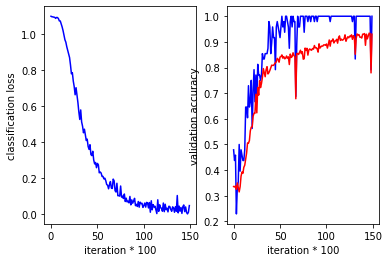

In [ ]:
start_t = timer()

average_training_losses = []
training_losses = []
average_val_accs = []
average_train_accs = []
val_accs = []
train_accs = []
id_iter = 0
max_iter = 30000
stop_epoch = False

for epoch in range(10000):
  for (x_train_in, y_train_in) in train_dataloader:
    training_losses.append(train_step(x_train_in.float(), y_train_in, lstm_1, optim_1))  # training iteration
    
    id_iter = id_iter + 1

    if id_iter % 200 == 0:
      for x_val_in, y_val_in in val_dataloader:  # validation
        val_accs.append(eval_step(x_val_in.float(), y_val_in, lstm_1))
      for x_val_in, y_val_in in train_dataloader:  # training
        train_accs.append(eval_step(x_train_in.float(), y_train_in, lstm_1))
      # report average val acc
      average_val_accs.append(sum(val_accs) / len(val_accs))
      average_train_accs.append(sum(train_accs) / len(train_accs))
      # report average training loss
      average_training_losses.append(sum(training_losses) / len(training_losses))
      # reset averages
      training_losses = []
      val_accs = []
      train_accs = []
      # print info
      print("ITER  {}: training loss       = {:.4f}".format(id_iter, average_training_losses[-1]))
      print("        : validation accuracy = {:.4f}".format(average_val_accs[-1]))
      print("______________________________________")
    
    if id_iter >= max_iter:
      stop_epoch = True
      break
    
  if stop_epoch:
    break

end_t = timer()
print("time_elapsed: {}".format(end_t - start_t))

# plots
times = list(range(len(average_training_losses)))

fig = plt.figure()

ax = fig.add_subplot(121)
ax.plot(times, average_training_losses, 'b')
ax.set_xlabel("iteration * 200")
ax.set_ylabel("classification loss")

ax = fig.add_subplot(122)
ax.plot(times, average_train_accs, 'b')
ax.plot(times, average_val_accs, 'r')
ax.set_xlabel("iteration * 200")
ax.set_ylabel("validation accuracy")

Comment this result

#### QUESTION 6 (Bonus)

Try to play with the learning rate and see how it affects your training

#### QUESTION 7 (Bonus)

Try to modify the FC classifier (had hidden layers) and see how it affects performances